### Keyword-Based News Classification Model

In [1]:
import pandas as pd
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import random

In [4]:
# Loading the  JSON file into a DataFrame

df = pd.read_json(r"C:\Users\bbuser\Downloads\News_Category_Dataset_v3.json", lines=True)
df.shape
df.head()


link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

In [6]:
#getting the category 
category = ["POLITICS", "WELLNESS", "TRAVEL", "SPORTS", "HOME & LIVING"]
df_filtered = df[df['category'].isin(category)]
df_filtered["category"].value_counts()

category
POLITICS         35602
WELLNESS         17945
TRAVEL            9900
SPORTS            5077
HOME & LIVING     4320
Name: count, dtype: int64

In [7]:
#now we take a sample of 5000 from each category to balance the dataset
df_sampled = (df_filtered.groupby('category', group_keys=False).sample(n=1000, random_state=42))
df_sampled['category'].value_counts()

category
HOME & LIVING    1000
POLITICS         1000
SPORTS           1000
TRAVEL           1000
WELLNESS         1000
Name: count, dtype: int64

In [9]:
#now we do the 20 80 spit train and test
train_df, test_df = train_test_split(df_sampled, test_size=0.2, random_state=42, stratify=df_sampled['category'])
print(train_df)
print(test_df)

                                                     link  \
59995   https://www.huffingtonpost.com/entry/trump-his...   
197058  https://www.huffingtonpost.com/entry/food-diar...   
177901  https://www.huffingtonpost.com/entry/new-years...   
157236  https://www.huffingtonpost.com/entry/detour-to...   
181884  https://www.huffingtonpost.com/entry/how-to-re...   
...                                                   ...   
205696  https://www.huffingtonpost.com/entry/how-to-dr...   
157040  https://www.huffingtonpost.com/entry/dave-dema...   
74105   https://www.huffingtonpost.com/entry/donald-tr...   
182279  https://www.huffingtonpost.com/entry/splurge-v...   
203447  https://www.huffingtonpost.com/entry/time-mana...   

                                                 headline       category  \
59995   The Party Of Honest Abe Now Stuck With Dishone...       POLITICS   
197058  The Power of the Written Word: Keeping a Food ...       WELLNESS   
177901               Stick Fearlessly t

### 2. Exploratory Analysis: Word Clouds + Frequent Words

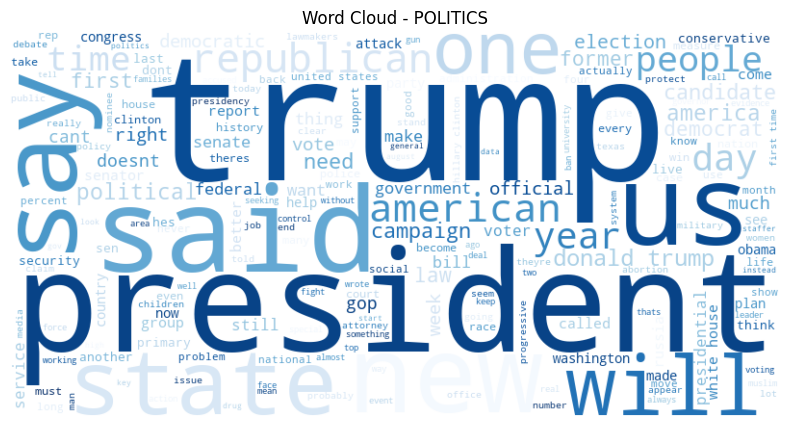

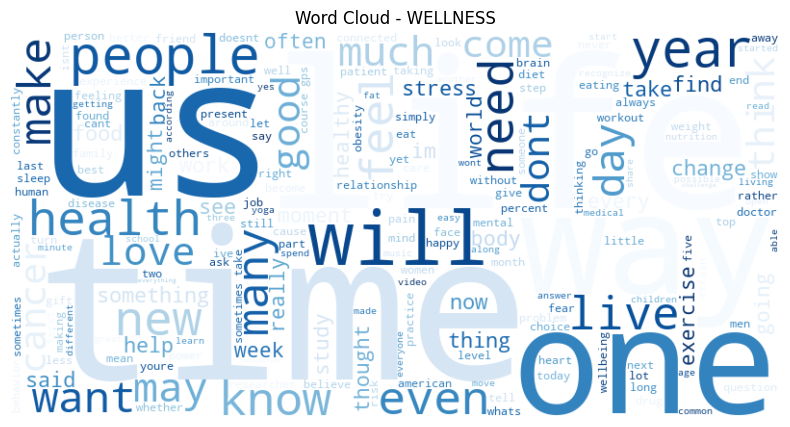

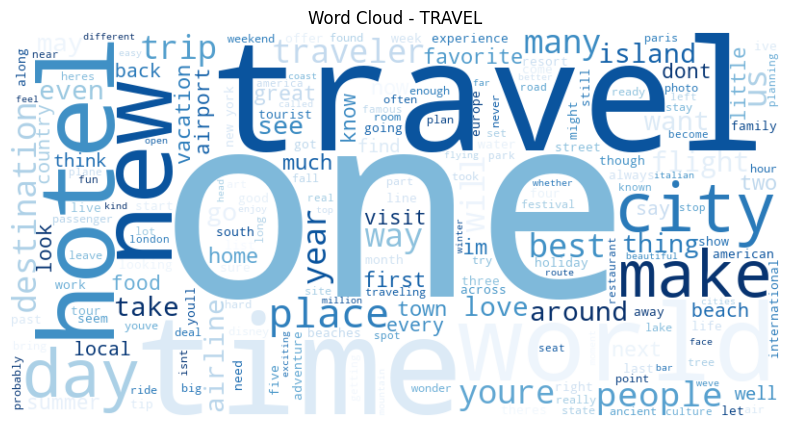

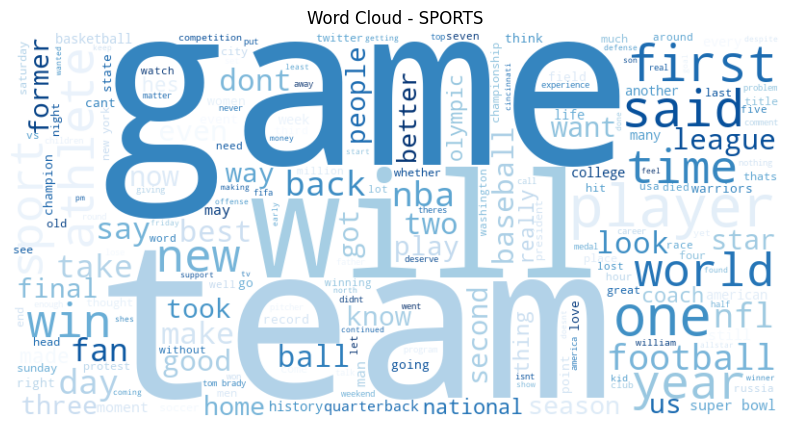

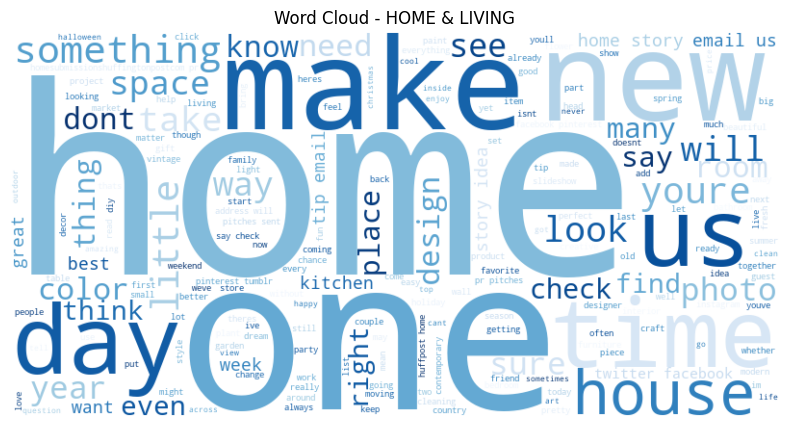

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

category_words = {}

for cat in category:
    # Combine all short_description texts for this category
    text = " ".join(train_df[train_df['category'] == cat]['short_description'].apply(clean_text))
    
    # Generate and show word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='Blues').generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {cat}")
    plt.show()
    
    # Save top frequent words
    words = text.split()
    most_common = [w for w, _ in Counter(words).most_common(50)]
    category_words[cat] = set(most_common)

### 3. Keyword-based Classification

In [11]:
def classify_by_keywords(description, category_words, top_n_words=None):
    words = set(clean_text(description).split())
    scores = {}
    for cat, freq_words in category_words.items():
        selected_words = set(list(freq_words)[:top_n_words]) if top_n_words else freq_words
        scores[cat] = len(words & selected_words)
    
    max_score = max(scores.values())
    top_categories = [cat for cat, score in scores.items() if score == max_score]
        # Randomly choose among ties or no overlap
    return random.choice(top_categories)

In [12]:
import random

def classify_by_keywords(description, category_words, top_n_words=None):
    words = set(clean_text(description).split())
    scores = {}

    print("Top words considered per category:")
    for cat, freq_words in category_words.items():
        selected_words = set(list(freq_words)[:top_n_words]) if top_n_words else freq_words
        print(f"{cat} ({len(selected_words)} words): {list(selected_words)[:10]} ...")  # show first 10 words
        scores[cat] = len(words & selected_words)
    
    max_score = max(scores.values())
    top_categories = [cat for cat, score in scores.items() if score == max_score]
    
    predicted_category = random.choice(top_categories) if top_categories else "unknown"
    return predicted_category

### 4. Experimentation

In [14]:
# Evaluate accuracy for different top-N word selections
top_words_list = [10, 20, 50, 100, 200]
results = {}

for top_n in top_words_list:
    predictions = test_df['short_description'].apply(lambda x: classify_by_keywords(x, category_words, top_n_words=top_n))
    accuracy = (predictions == test_df['category']).mean()
    results[top_n] = accuracy
    print(f"Top-{top_n} words accuracy: {accuracy:.4f}")

Top words considered per category:
POLITICS (10 words): ['its', 'this', 'have', 'will', 'he', 'is', 'they', 'state', 'said', 'has'] ...
WELLNESS (10 words): ['its', 'my', 'this', 'have', 'will', 'can', 'is', 'time', 'what', 'when'] ...
TRAVEL (10 words): ['its', 'my', 'this', 'is', 'so', 'they', 'what', 'some', 'has', 'when'] ...
SPORTS (10 words): ['its', 'this', 'have', 'will', 'game', 'is', 'they', 'what', 'said', 'has'] ...
HOME & LIVING (10 words): ['its', 'this', 'have', 'will', 'can', 'but', 'is', 'what', 'some', 'when'] ...
Top words considered per category:
POLITICS (10 words): ['its', 'this', 'have', 'will', 'he', 'is', 'they', 'state', 'said', 'has'] ...
WELLNESS (10 words): ['its', 'my', 'this', 'have', 'will', 'can', 'is', 'time', 'what', 'when'] ...
TRAVEL (10 words): ['its', 'my', 'this', 'is', 'so', 'they', 'what', 'some', 'has', 'when'] ...
SPORTS (10 words): ['its', 'this', 'have', 'will', 'game', 'is', 'they', 'what', 'said', 'has'] ...
HOME & LIVING (10 words): ['it

### 5. Plot Results

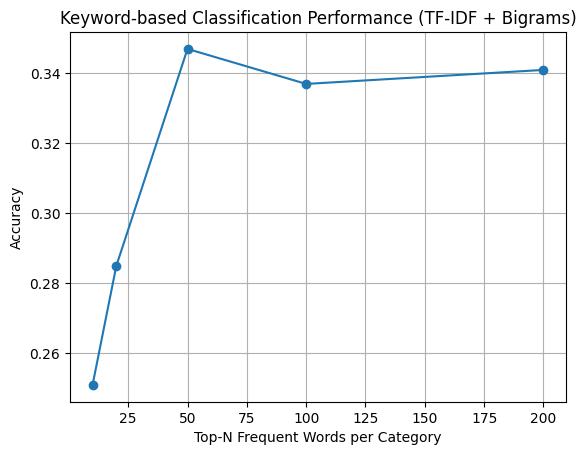

In [16]:
plt.plot(list(results.keys()), list(results.values()), marker="o")
plt.xlabel("Top-N Frequent Words per Category")
plt.ylabel("Accuracy")
plt.title("Keyword-based Classification Performance (TF-IDF + Bigrams)")
plt.grid(True)
plt.show()